# Plot and compare structure of equatorial Pacific thermocline between various ACCESS-OM2 simulations and observations

Plots include an equatorial Pacific depth-longitude slice, a depth-latitude slice at $140^\circ$W and vertical profiles of both the temperature and zonal velocity. 

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import sys, os

import cosima_cookbook as cc

from dask.distributed import Client

In [55]:
session = cc.database.create_session('/home/561/rmh561/access-om2/cc_database.db')
sessionD = cc.database.create_session()

In [76]:
# Define experiment dictionary
from collections import OrderedDict
exptdict = OrderedDict([
    ('1deg',   {'model':'access-om2 IAF', 'expt':'1deg_jra55v13_iaf_spinup1_B1', # 1deg IAF run from Kiss et al. 2020
                'desc': 'ACCESS-OM2','n_files':-12, 'itime':pd.datetime(1998,1,1), 'ftime':None,'db': sessionD}),
    ('025deg', {'model':'access-om2-025 IAF', 'expt':'025deg_jra55v13_iaf_gmredi6', # 025deg IAF run from Kiss et al. 2020
                    'desc': 'ACCESS-OM2-025','n_files':-34, 'itime':pd.datetime(1998,1,1),'ftime':None,'db': sessionD}),
    ('01deg',  {'model':'access-om2-01 IAF',  'expt':'01deg_jra55v13_iaf', # 01deg IAF run from Kiss et al. 2020
                'desc': 'ACCESS-OM2-01','n_files':None, 'itime':pd.datetime(1998,1,1),'ftime':None,'db': sessionD}),
    ('1degRYF',   {'model':'access-om2 RYF', 'expt':'1deg_jra55_ryf9091_gadi', # 1deg 9091RYF run
                'desc': 'ACCESS-OM2','n_files':-1, 'itime': None,'ftime':None,'db': session}),
    ('025degRYF', {'model':'access-om2-025 RYF', 'expt':'025deg_jra55_ryf9091_gadi', # 025deg 9091RYF run
                    'desc': 'ACCESS-OM2-025','n_files':-5, 'itime': None,'ftime':None,'db': session}),
    ('01degRYF',  {'model':'access-om2-01 RYF',  'expt':'01deg_jra55v13_ryf9091', # 01deg 9091RYF run
                    'desc': 'ACCESS-OM2-01','n_files':-40, 'itime': None,'ftime':None,'db': session}),
    ('01degRYF_0Kv',  {'model':'access-om2-01',  'expt':'01deg_jra55v13_ryf9091_0Kv', # 01deg 9091RYF run with no Kback
                    'desc': 'ACCESS-OM2-01','n_files':-40, 'itime': None,'ftime':None,'db': session}),
    ('01degRYF_5Kv',  {'model':'access-om2-01',  'expt':'01deg_jra55v13_ryf9091_5Kv', # 01deg 9091RYF run with 5e-6 Kback
                'desc': 'ACCESS-OM2-01','n_files':-40, 'itime': None,'ftime':None,'db': session})
])
# Compare 1/10th-degree model runs (different timing):
exptdict = OrderedDict([
    ('01degRYF',  {'model':'access-om2-01 RYF',  'expt':'01deg_jra55v13_ryf9091', # 01deg 9091RYF run
                    'desc': 'ACCESS-OM2-01','n_files':None, 'itime':pd.datetime(2060,1,1),'ftime':pd.datetime(2061,1,1),'db': session}),
    ('01degRYF_0Kv',  {'model':'access-om2-01',  'expt':'01deg_jra55v13_ryf9091_0Kv', # 01deg 9091RYF run with no Kback
                    'desc': 'ACCESS-OM2-01','n_files':None, 'itime':pd.datetime(2060,1,1),'ftime':pd.datetime(2061,1,1),'db': session}),
    ('01degRYF_5Kv',  {'model':'access-om2-01',  'expt':'01deg_jra55v13_ryf9091_5Kv', # 01deg 9091RYF run with 5e-6 Kback
                'desc': 'ACCESS-OM2-01','n_files':None, 'itime':pd.datetime(2060,1,1),'ftime':pd.datetime(2061,1,1),'db': session})
])

In [57]:
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:39803 Dashboard: http://127.0.0.1:33322/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [58]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## Define functions to get slices

In [75]:
# Get Equatorial profile at longitude lon
def find_Eqpt(ekey,lon):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    sess = exptdict[ekey]['db']
    
    temp = cc.querying.getvar(expt, 'temp',sess,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc')
    temp_eq = temp.sel(st_ocean=slice(0,400)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice(itime,ftime))\
                        .mean('time').load() - 273.15
    u = cc.querying.getvar(expt, 'u',sess,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc')
    u_eq = u.sel(st_ocean=slice(0,400)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').sel(time=slice(itime,ftime))\
                        .mean('time').load()*100

    return temp_eq, u_eq

# Get equatorial slice and 140W slice
def find_temp(ekey):
    
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    sess = exptdict[ekey]['db']
   
    temp = cc.querying.getvar(expt, 'temp',sess,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc')
    upper_temp_eq = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=slice(-217,-95)).sel(time=slice(itime,ftime))\
                        .mean('time').load() - 273.15
    upper_temp_140w = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=slice(-8,10))\
                        .sel(xt_ocean=-140.,method='nearest').sel(time=slice(itime,ftime))\
                        .mean('time').load() - 273.15

    return upper_temp_eq, upper_temp_140w


def find_u(ekey):
    
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    sess = exptdict[ekey]['db']

    u = cc.querying.getvar(expt, 'u',sess,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean.nc')
    upper_u_eq = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=slice(-217,-95)).sel(time=slice(itime,ftime))\
                        .mean('time').load()*100
    upper_u_140w = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=slice(-8,10))\
                        .sel(xu_ocean=-140.,method='nearest').sel(time=slice(itime,ftime))\
                        .mean('time').load()*100

    return upper_u_eq, upper_u_140w


## Plot Equatorial and 140W slices

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/cosima_cookbook/querying.py:134: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  **xr_kwargs
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/g/data3/hh5/public/apps/min

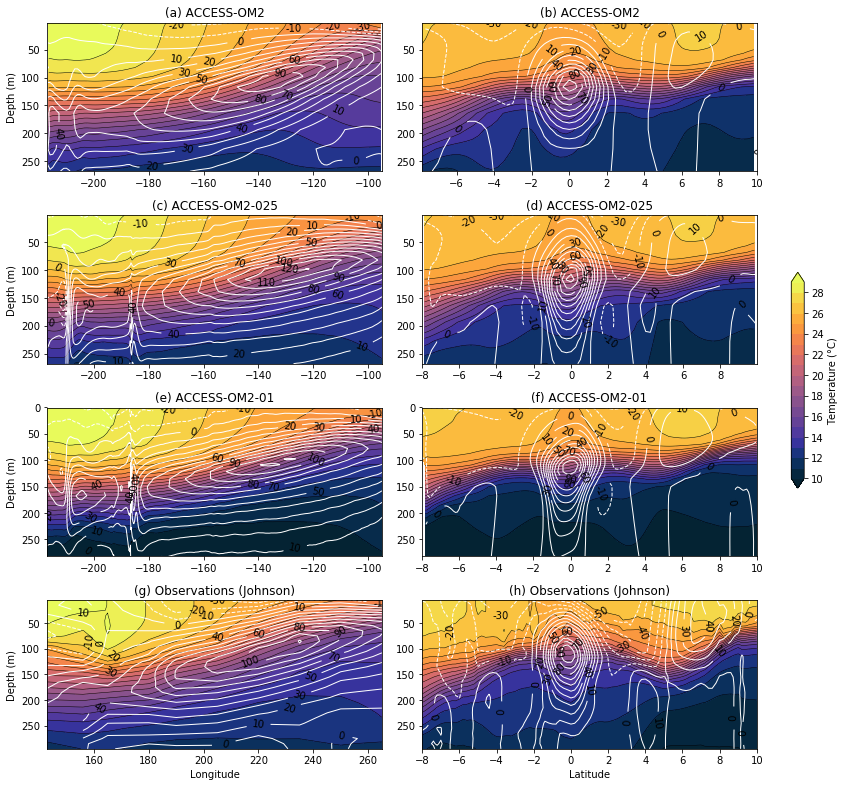

In [60]:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ']

fig = plt.figure(figsize=(12,12))

# IAF runs:
ekeys = ['1deg','025deg','01deg']
#ekeys = ['1degRYF']#,'025degRYF','01degRYF']
for i, ekey in enumerate(ekeys):
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    plt.subplot(4,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
    #    p2=upper_u_eq.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + exptdict[ekey]['desc'])


    plt.subplot(4,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
    #    p4=upper_u_140w.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + exptdict[ekey]['desc'])

obs_file = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=220, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

obs_u = obs_file['UM']
obs_u_140w = obs_u.sel(ZDEP1_50=slice(0,300)).sel(XLON=220., method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
obs_u_eq = obs_u.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
lon_u_obs = obs_u_eq.XLON

plt.subplot(4,2,7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('(g) Observations (Johnson)')


plt.subplot(4,2,8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('(h) Observations (Johnson)')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Temperature (°C)')

fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
#savefigure('equatorial_pacific_RYF')

## Make Vertical profiles at 3 longitudes:


In [61]:
# TAO data function:
obs_th = 2500
def get_TAO(lonTAO):
    tao_file_temp = xr.open_dataset('/g/data/e14/rmh561/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    tao_file_u = xr.open_dataset('/g/data/e14/rmh561/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    tao_file_uc = xr.open_dataset('/g/data/e14/rmh561/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    temp_WOA13_10 = cc.querying.getvar('woa13/10_KDS50', 'temp',session, ncfile='woa13_ts_??_mom10.nc').mean('time').sel(GRID_Y_T=0.,method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA,method='nearest')
    
    return woa_temp_eq

# {-140.,'140w',220.,-140.}

In [50]:
df = cc.querying.get_variables(session,expt)
df.loc[df['name']=='temp']

,name,frequency,ncfile,# ncfiles,time_start,time_end
255,temp,1 monthly,output197/ocean/ocean.nc,394,1984-12-30 00:00:00,2017-12-30 00:00:00


In [115]:
ekey = '01degRYF'
expt = exptdict[ekey]['expt']
n_files = exptdict[ekey]['n_files']
itime = exptdict[ekey]['itime']
ftime = exptdict[ekey]['ftime']
sess = exptdict[ekey]['db']
    
temp = cc.querying.getvar(expt, 'temp',sess,
        chunks={'st_ocean': None}, start_time='1900-01-01')

ValueError: cannot infer dimension to concatenate: supply the ``concat_dim`` argument explicitly

In [109]:
help(querying)

<xarray.DataArray 'temp' (time: 3370, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(3370, 75, 2700, 3600), dtype=float32, chunksize=(3, 75, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2077-04-16 00:00:00 ... 2077-03-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/cosima_cookbook/querying.py:134: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  **xr_kwargs
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.10/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


TypeError: Cannot convert bool to numpy.ndarray

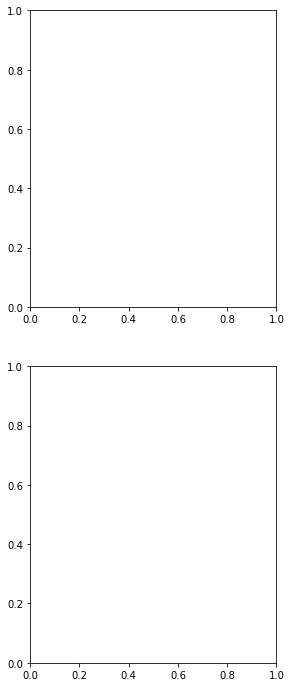

In [77]:
# Plot Profiles:
f = plt.figure(figsize=(15,12),facecolor='white')
lons = {'165e': {'mod': -195.,'tao': '165e','joh': 165.,'woa': -195.},
        '140w': {'mod': -140.,'tao': '140w','joh': 220.,'woa': -140.},
        '110w': {'mod': -110.,'tao': '110w','joh': 250.,'woa': -110.}
        }
#ekeys = ['1deg','1degRYF']
#ekeys = ['025deg','025degRYF']
#ekeys = ['01deg','01degRYF']
#ekeys = ['1degRYF','025degRYF','01degRYF']
ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv']
nln = len(lons)
tax = []
uax = []
for j, lkey in enumerate(lons.keys()):
         
    tax.append(plt.subplot(2,nln,j+1))
    uax.append(plt.subplot(2,nln,j+nln+1))

    for i, ekey in enumerate(ekeys):
        t_eq, u_eq = find_Eqpt(ekey,lons[lkey]['mod'])
        tax[j].plot(t_eq.values,-t_eq.st_ocean.values,label=exptdict[ekey]['model'],linewidth=2)
        uax[j].plot(u_eq.values,-u_eq.st_ocean.values,linewidth=2)

    tao_temp, tao_u, tao_uc = get_TAO(lons[lkey]['tao'])
    joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
    #woa_temp_eq = get_WOA(lons[lkey]['woa'])
    
    tax[j].plot(tao_temp.mean('time'),-tao_temp.depth,'--',linewidth=2,label='TAO')
    tax[j].plot(joh_temp_eq,-dep_joh,'--',linewidth=2,label='Johnson et al')
    #tax[j].plot(woa_temp_eq.values,-woa_temp_eq.ZT.values,'--',linewidth=2,label='WOA13')
    tax[j].set_xlabel('Temperature ($^\circ$C)')
    tax[j].set_ylabel('Depth (m)')
    tax[j].legend(loc=2)
    tax[j].set_ylim([-300.,0.])
    tax[j].set_xlim([8.,30.])
    tax[j].set_title(lons[lkey]['tao'] + ', 0N Temperature')
 
    uax[j].plot(tao_u.mean('time')*100.,-tao_u.depth,'--',linewidth=2)
    # uax[j].plot(tao_uc.mean('time')*100.,-tao_uc.depth,':',linewidth=2)
    uax[j].plot(joh_u_eq*100.,-dep_joh,'--',linewidth=2)
    uax[j].set_xlabel('Zonal Velocity (ms$^{-1}$)')
    uax[j].set_ylabel('Depth (m)')
    uax[j].set_ylim([-300.,0.])
    uax[j].set_title(lons[lkey]['tao'] + ', 0N Zonal Velocity')
    
savefigure('Equatorial_Pacific_profiles_110W_140W_165E_01degKv')